In [5]:
!pip install mesa==1.1.1


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 330.3 kB/s eta 0:00:06
   - -------------------------------------- 0.1/1.8 MB 491.5 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.8 MB 595.3 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.8 MB 568.9 kB/s eta 0:00:03
   --- ------------------------------------ 0.2/1.8 MB 619.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.8 MB 686.8 kB/s eta 0:00:03
   ----- ---------------------------------- 0.3/1.8 MB 713.1 kB/s eta 0:00:03
   ------- -------------------------------- 0.3/1.8 MB 776.5 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.8 MB 773.3 kB/s eta 0:00:02
   -------- ------------------------------- 0.4/1.8 MB 778.2 kB/s eta 0:00:02
   --------- ------------------------------ 0.4/1.8 MB 767.5 kB/s eta 0:00:02
   -

[*********************100%%**********************]  1 of 1 completed


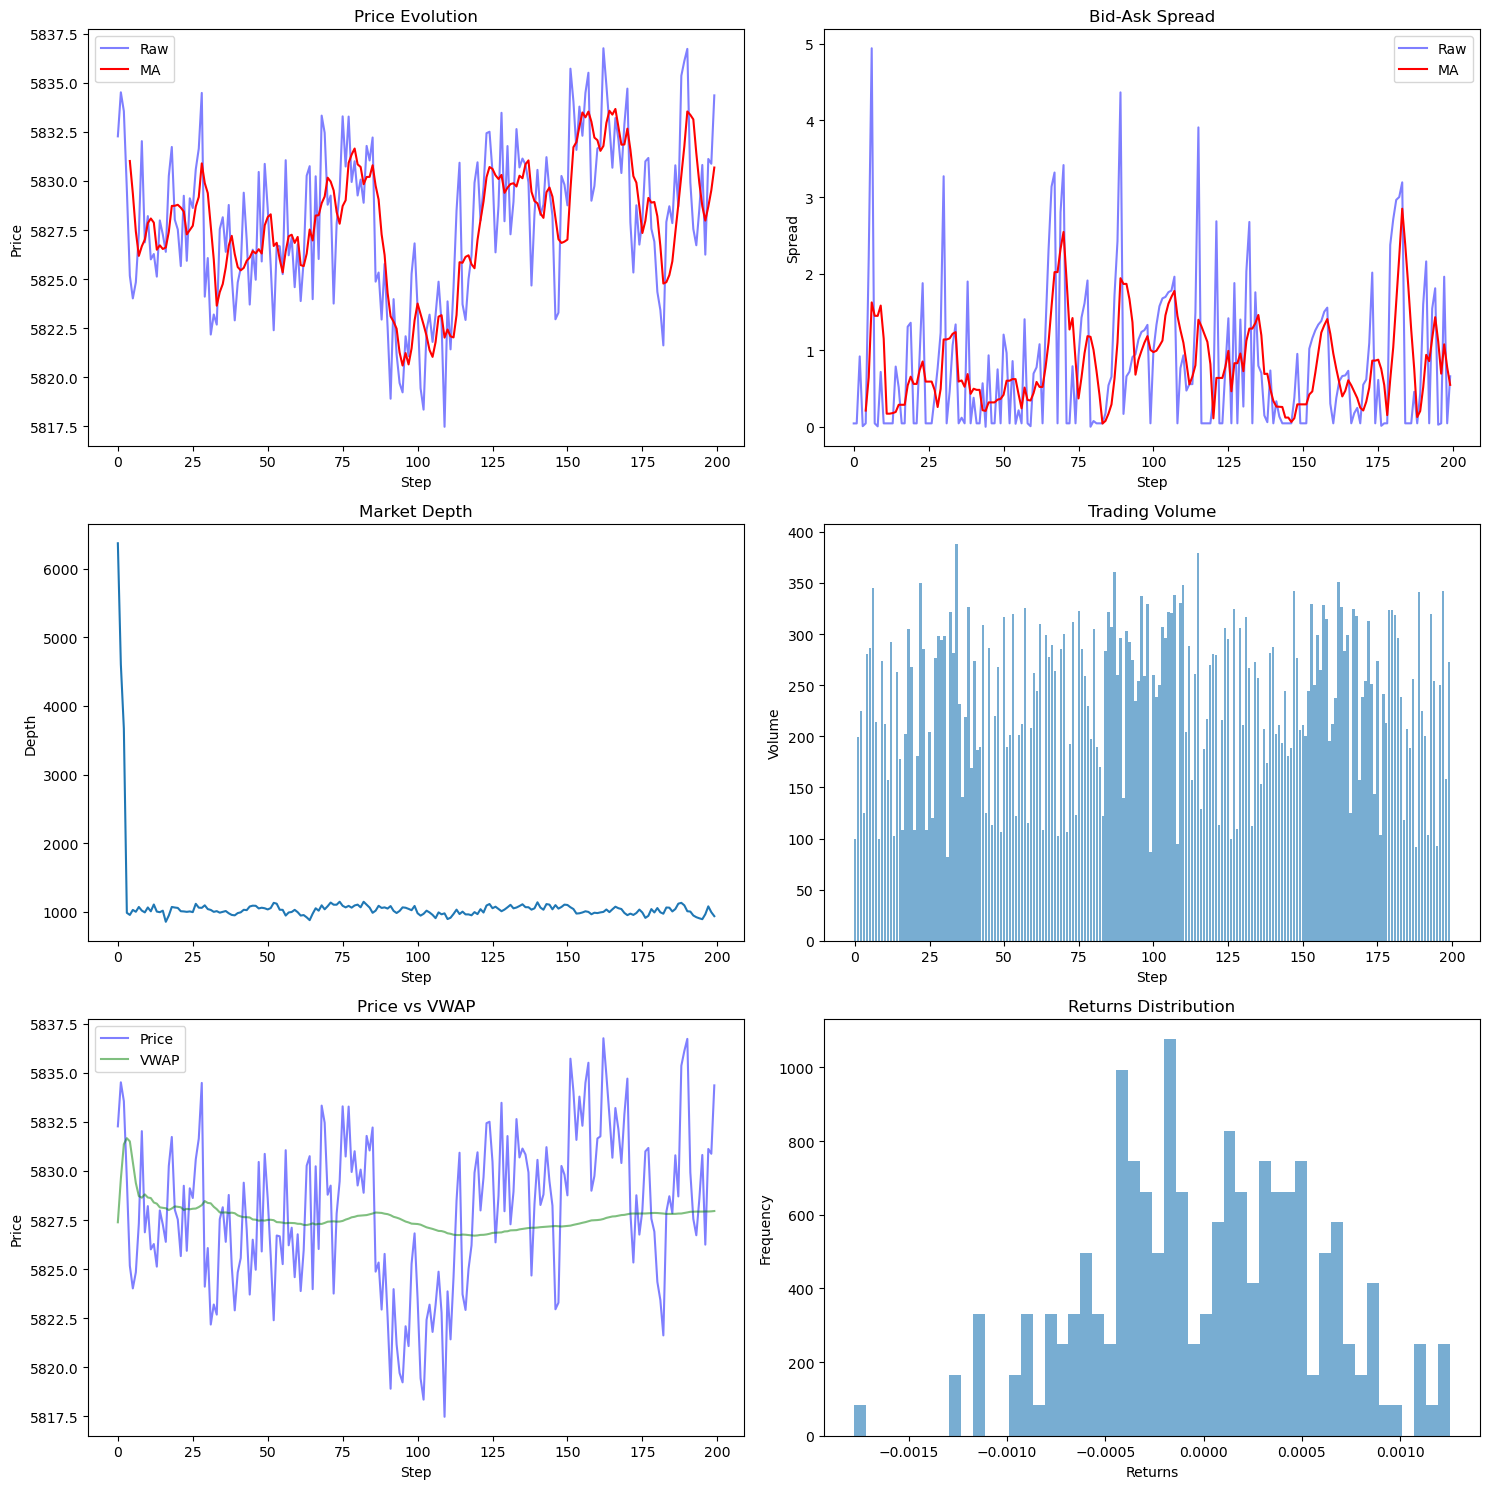

In [19]:


# Import required libraries
import numpy as np
import pandas as pd
import yfinance as yf
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class MarketData:
    """Enhanced class to handle S&P 500 data and market statistics"""
    def __init__(self, symbol='^GSPC', period='1y'):
        self.symbol = symbol
        self.data = self._fetch_market_data(period)
        self.volatility = self._calculate_volatility()
        self.average_volume = self.data['Volume'].mean()
        self.price_history = []
        
    def _fetch_market_data(self, period):
        try:
            data = yf.download(self.symbol, period=period, interval='1d')
            data['Returns'] = data['Adj Close'].pct_change()
            data['Volatility'] = data['Returns'].rolling(window=20).std()
            return data
        except Exception as e:
            print(f"Error fetching market data: {e}")
            return pd.DataFrame()
    
    def _calculate_volatility(self):
        return self.data['Returns'].std() if not self.data.empty else 0.01
    
    def get_current_price(self):
        return self.data['Adj Close'].iloc[-1] if not self.data.empty else 100.0
    
    def get_historical_volatility(self, window=20):
        return self.data['Volatility'].iloc[-1] if not self.data.empty else 0.01
    
    def update_price_history(self, price):
        self.price_history.append(price)
        if len(self.price_history) > 100:
            self.price_history.pop(0)

class Order:
    """Enhanced order class with sophisticated price levels and timestamps"""
    def __init__(self, order_type, size, price, trader_id, timestamp=None):
        self.order_type = order_type
        self.size = size
        self.price = price
        self.trader_id = trader_id
        self.timestamp = timestamp or datetime.now()
        self.status = 'ACTIVE'
        self.filled_size = 0
        
    def fill(self, size):
        fill_size = min(size, self.size - self.filled_size)
        self.filled_size += fill_size
        if self.filled_size >= self.size:
            self.status = 'FILLED'
        return fill_size

class OrderBook:
    def __init__(self):
        self.bids = []
        self.asks = []
        self.trades = []
        self.trade_prices = []
        self.daily_volume = 0  # Add daily volume tracker
        
    def add_order(self, order):
        if order.order_type == 'BUY':
            self.bids.append(order)
            self.bids.sort(key=lambda x: (-x.price, x.timestamp))
        else:
            self.asks.append(order)
            self.asks.sort(key=lambda x: (x.price, x.timestamp))
            
    def match_orders(self):
        trades = []
        step_volume = 0  # Track volume for this step
        
        while self.bids and self.asks:
            best_bid = self.bids[0]
            best_ask = self.asks[0]
            
            if best_bid.price >= best_ask.price:
                trade_price = (best_bid.price + best_ask.price) / 2
                trade_size = min(best_bid.size - best_bid.filled_size,
                               best_ask.size - best_ask.filled_size)
                
                best_bid.fill(trade_size)
                best_ask.fill(trade_size)
                
                step_volume += trade_size  # Add to step volume
                
                trades.append({
                    'price': trade_price,
                    'size': trade_size,
                    'timestamp': datetime.now(),
                    'buyer': best_bid.trader_id,
                    'seller': best_ask.trader_id
                })
                
                self.trade_prices.append(trade_price)
                
                if best_bid.status == 'FILLED':
                    self.bids.pop(0)
                if best_ask.status == 'FILLED':
                    self.asks.pop(0)
            else:
                break
        
        self.daily_volume = step_volume  # Update daily volume
        return trades
    
    def get_vwap(self):
        return np.mean(self.trade_prices) if self.trade_prices else None
    
    def cleanup_old_orders(self, timeout_minutes=5):
        current_time = datetime.now()
        self.bids = [order for order in self.bids 
                    if (current_time - order.timestamp).total_seconds() < timeout_minutes * 60]
        self.asks = [order for order in self.asks 
                    if (current_time - order.timestamp).total_seconds() < timeout_minutes * 60]

class MarketMaker(Agent):
    """Enhanced market maker with sophisticated pricing and risk management"""
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        self.inventory = 10000
        self.risk_aversion = 0.5
        self.cash = 1000000
        self.position_limit = self.inventory * 2
        self.inventory_history = []
        self.pnl = 0
        self.bid = None
        self.ask = None
        self.min_spread = 0.01
        self.max_spread = 0.5
        
    def calculate_spread(self):
        base_spread = 0.02
        inventory_risk = (abs(self.inventory) / self.position_limit) * self.risk_aversion
        vol_adjustment = self.model.market_data.get_historical_volatility() * 100
        market_activity = len(self.model.order_book.bids) + len(self.model.order_book.asks)
        activity_adjustment = np.log1p(market_activity) * 0.01
        hour = datetime.now().hour
        time_factor = 1.0 + 0.1 * (hour < 10 or hour > 15)
        
        spread = base_spread * (1 + inventory_risk + vol_adjustment + activity_adjustment) * time_factor
        return max(self.min_spread, min(self.max_spread, spread))
        
    def step(self):
        mid_price = self.model.current_price * (1 + np.random.normal(0, 0.0001))
        spread = self.calculate_spread()
        
        inventory_skew = (self.inventory / self.position_limit) * spread * 0.5
        self.bid = mid_price - (spread/2) - inventory_skew
        self.ask = mid_price + (spread/2) - inventory_skew
        
        base_size = 100
        vol_adjustment = self.model.market_data.get_historical_volatility()
        bid_size = int(base_size * (1 + np.random.normal(0, 0.2)) * (1 + vol_adjustment))
        ask_size = int(base_size * (1 + np.random.normal(0, 0.2)) * (1 + vol_adjustment))
        
        bid_order = Order('BUY', bid_size, self.bid, self.unique_id)
        ask_order = Order('SELL', ask_size, self.ask, self.unique_id)
        
        self.model.order_book.add_order(bid_order)
        self.model.order_book.add_order(ask_order)
        self.inventory_history.append(self.inventory)

class SophisticatedTrader(Agent):
    """Enhanced trader with multiple trading strategies"""
    def __init__(self, unique_id, model, strategy_type='momentum'):
        self.unique_id = unique_id
        self.model = model
        self.strategy_type = strategy_type
        self.position = 0
        self.cash = 100000
        self.trade_history = []
        self.lookback_period = 20
        self.min_trade_size = 10
        self.max_trade_size = 1000
        
    def step(self):
        if self.strategy_type == 'momentum':
            order_type, size = self.momentum_strategy()
        else:
            order_type, size = self.mean_reversion_strategy()
            
        if order_type and size > self.min_trade_size:
            price = self.model.current_price * (0.99 if order_type == 'BUY' else 1.01)
            size = min(size, self.max_trade_size)
            order = Order(order_type, size, price, self.unique_id)
            self.model.order_book.add_order(order)
            self.trade_history.append((order_type, size, price))

    def momentum_strategy(self):
        returns = self.model.market_data.data['Returns'].iloc[-self.lookback_period:]
        momentum = returns.mean()
        if momentum > 0.0005:
            return 'BUY', self.calculate_position_size(momentum * 2)
        elif momentum < -0.0005:
            return 'SELL', self.calculate_position_size(abs(momentum) * 2)
        return None, 0
        
    def mean_reversion_strategy(self):
        prices = self.model.market_data.data['Adj Close'].iloc[-self.lookback_period:]
        current_price = prices.iloc[-1]
        mean_price = prices.mean()
        std_price = prices.std()
        z_score = (current_price - mean_price) / std_price
        
        if z_score > 1:
            return 'SELL', self.calculate_position_size(abs(z_score) * 0.1)
        elif z_score < -1:
            return 'BUY', self.calculate_position_size(abs(z_score) * 0.1)
        return None, 0
        
    def calculate_position_size(self, signal_strength):
        max_position = self.cash * 0.1
        volatility = self.model.market_data.get_historical_volatility()
        position_size = max_position * signal_strength * (1 / (volatility + 0.001))
        return min(max_position, position_size)

class LiquidityMetrics:
    """Enhanced liquidity metrics calculation"""
    @staticmethod
    def calculate_amihud_illiquidity(returns, volume, price):
        return abs(returns) / (volume * price) if volume > 0 else np.nan
    
    @staticmethod
    def calculate_bid_ask_spread(bids, asks):
        if not bids or not asks:
            return None
        return asks[0].price - bids[0].price if bids and asks else None
    
    @staticmethod
    def calculate_market_depth(order_book, price_levels=5):
        bid_depth = sum(order.size for order in order_book.bids[:price_levels])
        ask_depth = sum(order.size for order in order_book.asks[:price_levels])
        return bid_depth, ask_depth
    
    @staticmethod
    def calculate_market_impact(order_book, trade_size):
        """Calculate estimated market impact of a trade"""
        total_depth = sum(LiquidityMetrics.calculate_market_depth(order_book))
        return (trade_size / total_depth) if total_depth > 0 else np.nan

class EnhancedLiquidityModel(Model):
    def __init__(self, num_traders=20, num_market_makers=3):
        Model.__init__(self)
        self.num_agents = num_traders + num_market_makers
        self.market_data = MarketData()
        self.current_price = self.market_data.get_current_price()
        self.schedule = RandomActivation(self)
        self.order_book = OrderBook()
        self.liquidity_metrics = LiquidityMetrics()
        
        self._initialize_agents(num_traders, num_market_makers)
        
        self.datacollector = DataCollector(
            model_reporters={
                "Price": lambda m: m.current_price,
                "Spread": lambda m: m.liquidity_metrics.calculate_bid_ask_spread(
                    m.order_book.bids, m.order_book.asks),
                "Market_Depth": lambda m: sum(m.liquidity_metrics.calculate_market_depth(
                    m.order_book)),
                "Volume": lambda m: m.order_book.daily_volume,  # Use daily_volume
                "VWAP": lambda m: m.order_book.get_vwap()
            }
        )
    
    def _initialize_agents(self, num_traders, num_market_makers):
        for i in range(num_market_makers):
            mm = MarketMaker(f"MM_{i}", self)
            self.schedule.add(mm)
        
        strategies = ['momentum', 'mean_reversion']
        for i in range(num_traders):
            strategy = strategies[i % len(strategies)]
            trader = SophisticatedTrader(f"T_{i}", self, strategy)
            self.schedule.add(trader)
    
    def step(self):
        self.order_book.cleanup_old_orders()
        self.schedule.step()
        trades = self.order_book.match_orders()
        
        if trades:
            last_price = trades[-1]['price']
            self.current_price = last_price * (1 + np.random.normal(0, 0.0005))
        else:
            self.current_price *= (1 + np.random.normal(0, 0.0002))
            
        self.market_data.update_price_history(self.current_price)
        self.datacollector.collect(self)



def plot_results(results):
    """Enhanced visualization of results with fixed volume plot"""
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    
    # Price Evolution
    axes[0, 0].plot(results['Price'], 'b-', alpha=0.5, label='Raw')
    axes[0, 0].plot(results['Price'].rolling(window=5).mean(), 'r-', label='MA')
    axes[0, 0].set_title('Price Evolution')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend()
    
    # Spread Evolution
    if 'Spread' in results.columns:
        spread_data = results['Spread'].fillna(method='ffill')
        axes[0, 1].plot(spread_data, 'b-', alpha=0.5, label='Raw')
        axes[0, 1].plot(spread_data.rolling(window=5).mean(), 'r-', label='MA')
        axes[0, 1].set_title('Bid-Ask Spread')
        axes[0, 1].set_xlabel('Step')
        axes[0, 1].set_ylabel('Spread')
        axes[0, 1].legend()
    
    # Market Depth
    axes[1, 0].plot(results['Market_Depth'])
    axes[1, 0].set_title('Market Depth')
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Depth')
    
    # Trading Volume - Fixed plot
    volume_data = results['Volume'].fillna(0)  # Replace NaN with 0
    axes[1, 1].bar(range(len(volume_data)), volume_data, alpha=0.6)
    axes[1, 1].set_title('Trading Volume')
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Volume')
    
    # VWAP vs Price
    if 'VWAP' in results.columns:
        axes[2, 0].plot(results['Price'], 'b-', alpha=0.5, label='Price')
        axes[2, 0].plot(results['VWAP'].fillna(method='ffill'), 'g-', alpha=0.5, label='VWAP')
        axes[2, 0].set_title('Price vs VWAP')
        axes[2, 0].set_xlabel('Step')
        axes[2, 0].set_ylabel('Price')
        axes[2, 0].legend()
    
    # Price Returns Distribution
    returns = results['Price'].pct_change().dropna()
    axes[2, 1].hist(returns, bins=50, density=True, alpha=0.6)
    axes[2, 1].set_title('Returns Distribution')
    axes[2, 1].set_xlabel('Returns')
    axes[2, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def run_advanced_analysis():
    """Run the simulation with improved volume tracking"""
    model = EnhancedLiquidityModel(num_traders=20, num_market_makers=3)
    
    for _ in range(200):
        model.step()
    
    results = model.datacollector.get_model_vars_dataframe()
    plot_results(results)
    
    return results

if __name__ == "__main__":
    results = run_advanced_analysis()

SyntaxError: incomplete input (3939326053.py, line 9)